<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

In [3]:
trainset.targets.unique(return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [4]:
testset.targets.unique(return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [5]:
trainset.class_to_idx

{'o': 0,
 'ki': 1,
 'su': 2,
 'tsu': 3,
 'na': 4,
 'ha': 5,
 'ma': 6,
 'ya': 7,
 're': 8,
 'wo': 9}

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [6]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=6)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=6)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

The batch size affects some indicators such as overall training time, training time per epoch, quality of the model, and similar. The larger the size of the batch, the faster the model learns, but its quality may decrease. Therefore, it is necessary to maintain a balance.

Посмотрим на какую-нибудь картинку:

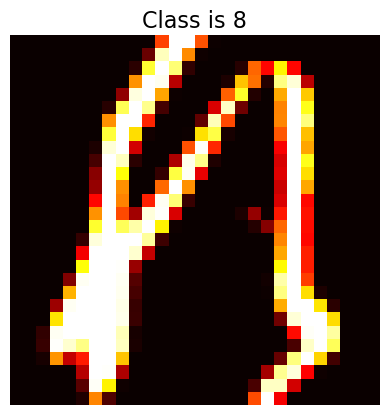

In [7]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="hot")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





In [8]:
# getting first batch to check unique classes and their indices
images, classes = next(iter(trainloader))
unique_classes, class_idx = np.unique(classes.numpy(), return_index=True)

In [9]:
class_idx

array([ 5,  9,  2, 22,  1, 12,  0, 13,  4, 26])

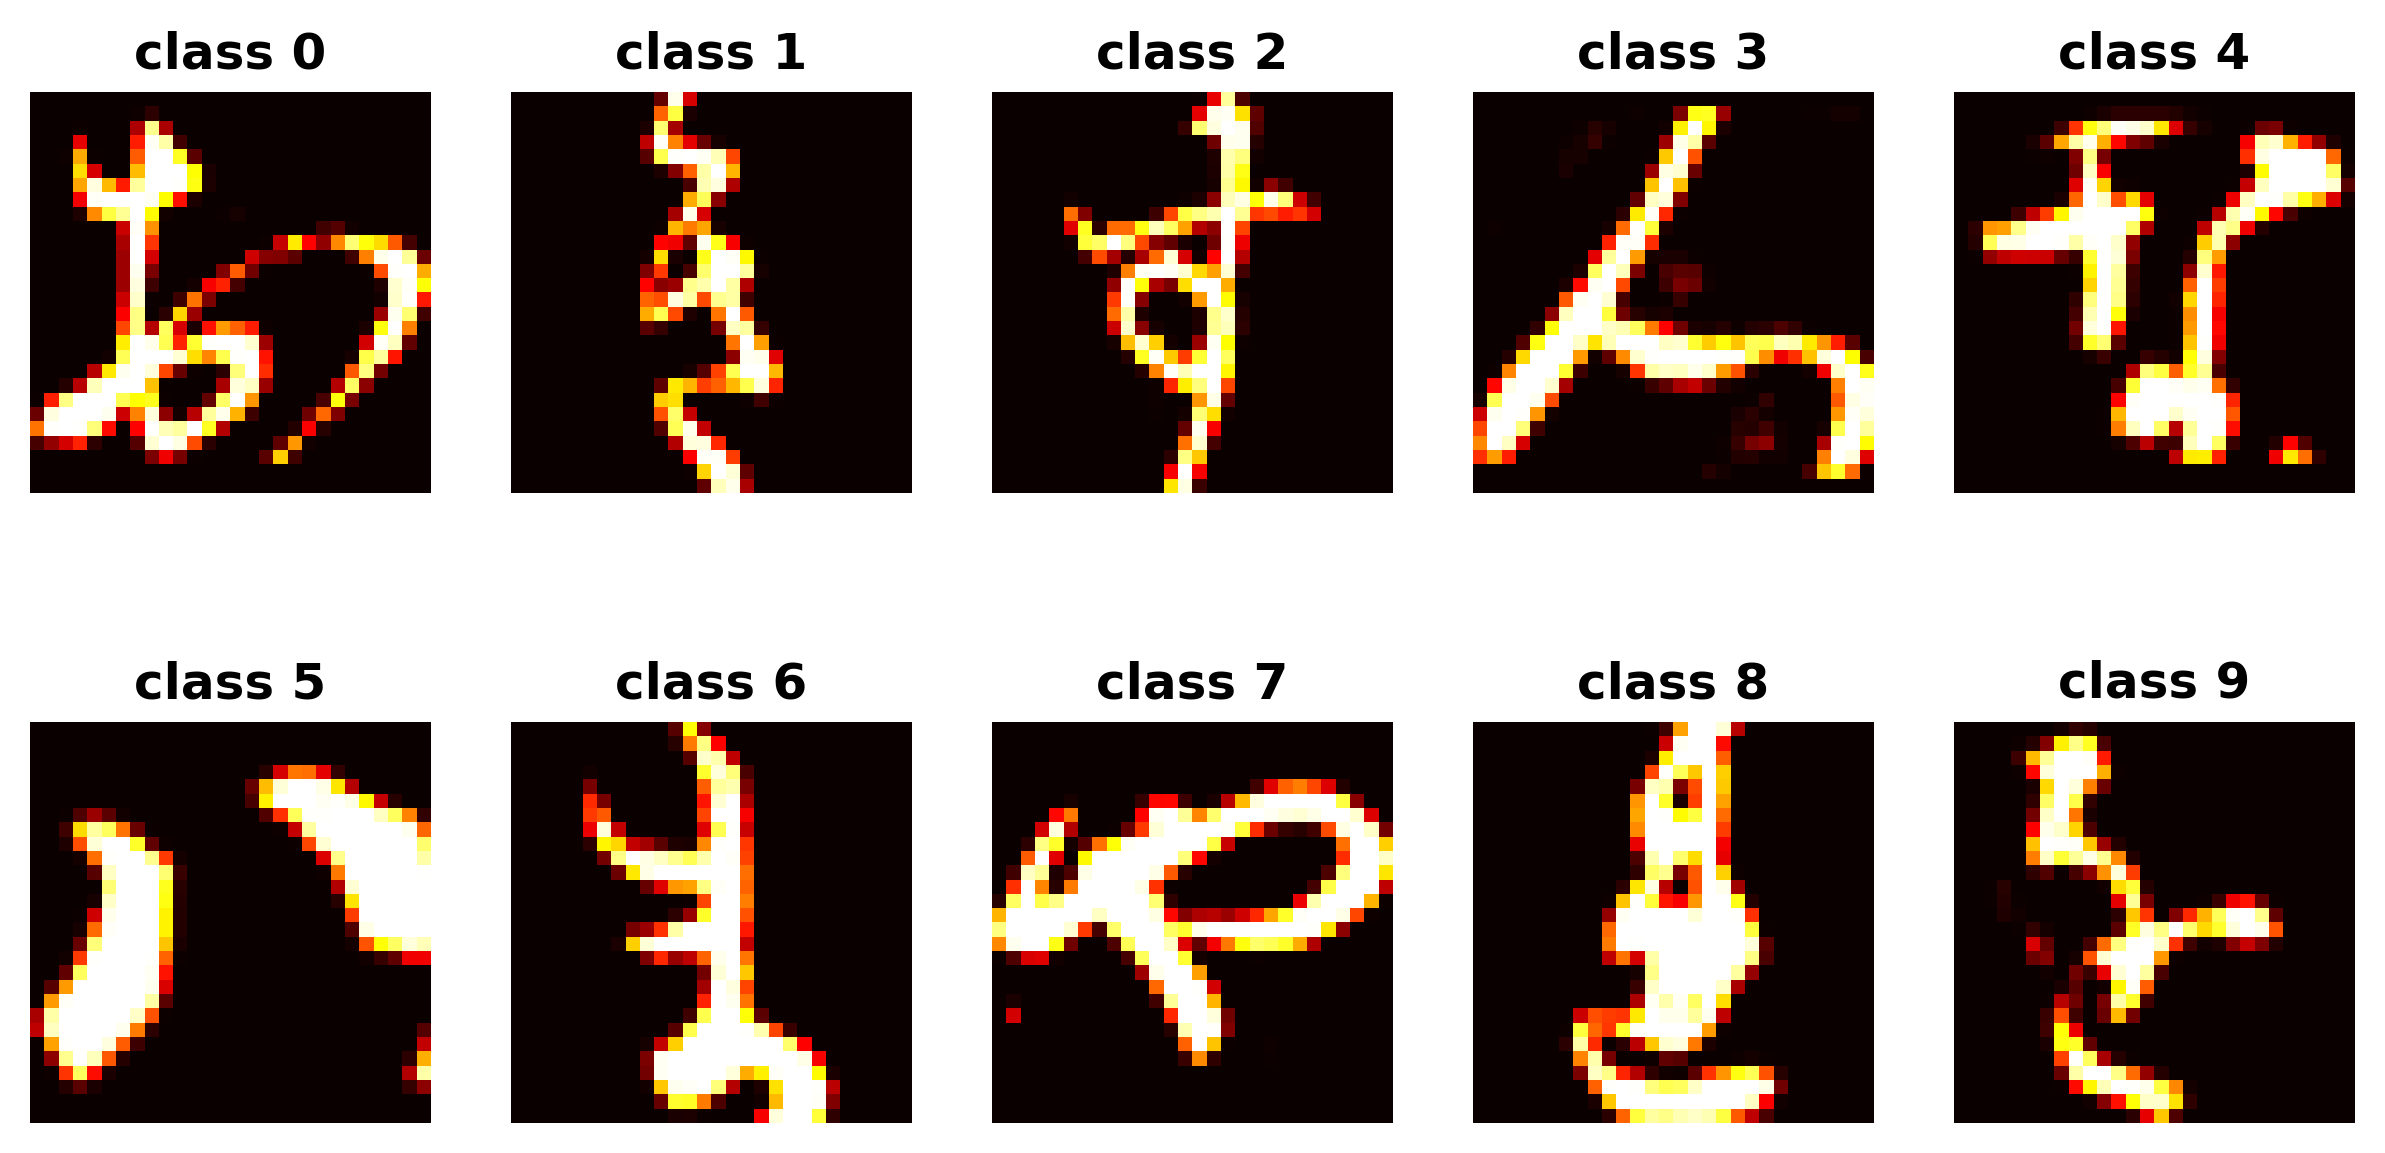

In [10]:

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(10, 5), dpi=300)

for cl, i, ax in zip(unique_classes, class_idx, axes.flat):
    class_repr = images[i].view(28, 28).numpy()
    ax.imshow(class_repr, cmap="hot") # looks like fire symbols:)
    ax.axis("off")
    ax.set_title(f'class {cl}', 
                 fontsize=12, 
                 fontweight='bold')
    
plt.show();

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [11]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        
        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = nn.LeakyReLU()
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        # we do not need activation after the last layer, since the subsequent CrossEntropyLoss 
        # will require logits as an input
        logits = self.fc3(x) 

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [12]:
net = FCNet()
net_params = net.parameters()
n = 0
for param in net_params:
    n += len(param.view(-1))
print(f"{n} model parameters")

235146 model parameters


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [13]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [14]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [15]:
def train_model(n_epochs, dataloader):
    loss_history = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in dataloader: # training batch
            optimizer.zero_grad() # to reset the gradient
            outputs = fc_net(images) # predicting
            loss = loss_function(outputs, labels) # calculating loss
            loss.backward() # calculating gradient
            optimizer.step() # step of gradient descent

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))

        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
    return loss_history

In [16]:
n_epochs = 10
loss_history = train_model(n_epochs, trainloader)

Epoch=1 loss=0.9194
Epoch=2 loss=0.4594
Epoch=3 loss=0.3605
Epoch=4 loss=0.3012
Epoch=5 loss=0.2585
Epoch=6 loss=0.2238
Epoch=7 loss=0.1950
Epoch=8 loss=0.1707
Epoch=9 loss=0.1505
Epoch=10 loss=0.1321


In [17]:
get_accuracy(fc_net, testloader)

0.8745

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [18]:
mean = trainset.data.to(torch.float32).mean(dim=(0, 1, 2)) / 255
std = trainset.data.to(torch.float32).std(dim=(0, 1, 2)) / 255
print(f"Mean pixel intensity: {mean:.4f}, std: {std:.4f}")

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

Mean pixel intensity: 0.1918, std: 0.3483


In [19]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [20]:
n_epochs = 10
loss_history_norm = train_model(n_epochs, trainloader)

Epoch=1 loss=0.6902
Epoch=2 loss=0.3064
Epoch=3 loss=0.2262
Epoch=4 loss=0.1780
Epoch=5 loss=0.1425
Epoch=6 loss=0.1163
Epoch=7 loss=0.0970
Epoch=8 loss=0.0801
Epoch=9 loss=0.0645
Epoch=10 loss=0.0533


In [21]:
get_accuracy(fc_net, testloader)

0.8973

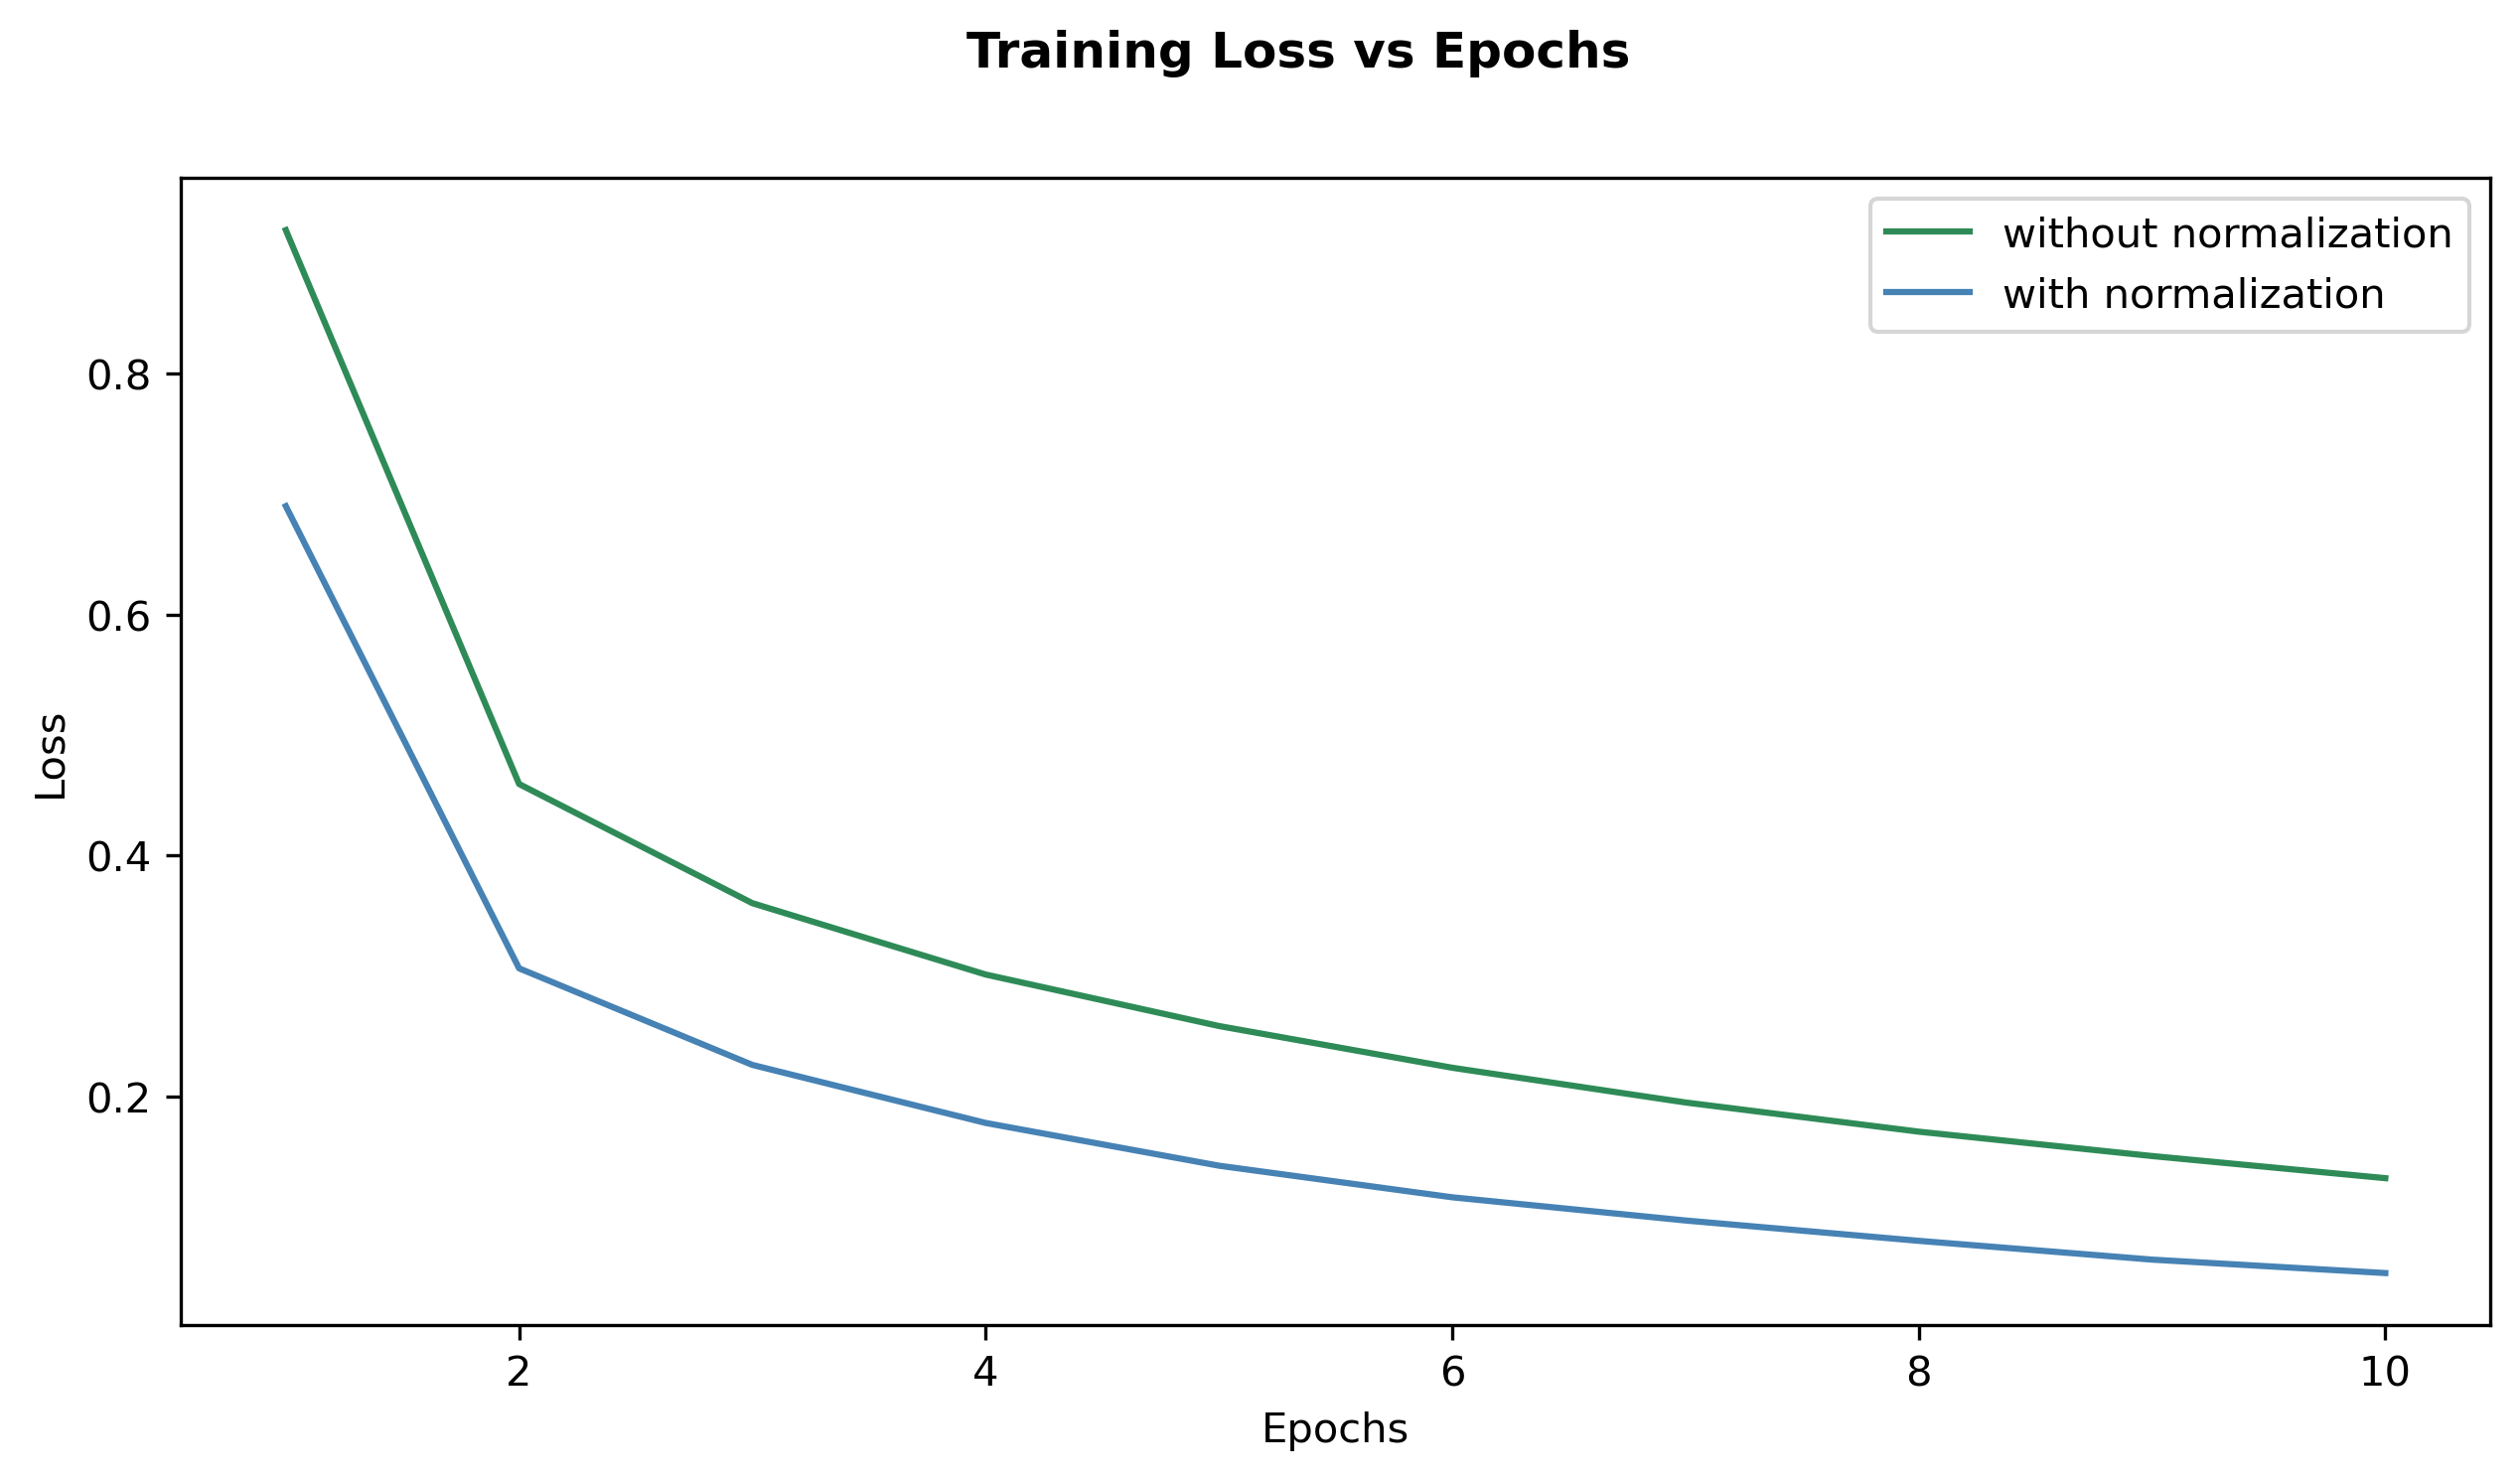

In [22]:
plt.figure(figsize=(10,5), dpi=300)
plt.plot([i+1 for i in range(n_epochs)], loss_history, color="seagreen", label="without normalization")
plt.plot([i+1 for i in range(n_epochs)], loss_history_norm, color="steelblue", label="with normalization")
plt.legend()
plt.suptitle("Training Loss vs Epochs", fontsize=12, fontweight='bold')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Как изменилась `accuracy` после нормализации?

**Ответ:**

The `accuracy` has increased slightly. But we know that data normalization is very important for neural networks.

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [23]:
class FCNet_act(nn.Module):
    def __init__(self, act_func):
        super().__init__() #  это надо помнить!
        
        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = act_func
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        # we do not need activation after the last layer, since the subsequent CrossEntropyLoss 
        # will require logits as an input
        logits = self.fc3(x) 

        return logits

In [25]:
def test_activation(n_epochs, dataloader, act_func):
    fc_net = FCNet_act(act_func[1])
    optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
    loss_history = []
    print(f"{act_func[0]}")
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in dataloader: # training batch
            optimizer.zero_grad() # to reset the gradient
            outputs = fc_net(images) # predicting
            loss = loss_function(outputs, labels) # calculating loss
            loss.backward() # calculating gradient
            optimizer.step() # step of gradient descent

            epoch_loss += loss.item()

        loss_history.append(epoch_loss / len(trainloader))
        
        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
    print(f"accuracy score: {get_accuracy(fc_net, testloader)}")
    return loss_history

In [26]:
loss_function = nn.CrossEntropyLoss()
n_epochs = 10
loss_histories = {}

act_funcs = [("sigmoid", nn.Sigmoid()), ("tahn", nn.Tanh()), 
             ("ReLU", nn.ReLU()), ("GELU", nn.GELU())]
for func in act_funcs:
    loss_history = test_activation(n_epochs, trainloader, func)
    loss_histories.update({func[0]: loss_history})

sigmoid
Epoch=1 loss=1.5201
Epoch=2 loss=0.7431
Epoch=3 loss=0.5422
Epoch=4 loss=0.4390
Epoch=5 loss=0.3685
Epoch=6 loss=0.3147
Epoch=7 loss=0.2714
Epoch=8 loss=0.2360
Epoch=9 loss=0.2067
Epoch=10 loss=0.1820
accuracy score: 0.8587
tahn
Epoch=1 loss=0.7795
Epoch=2 loss=0.3792
Epoch=3 loss=0.2553
Epoch=4 loss=0.1825
Epoch=5 loss=0.1361
Epoch=6 loss=0.1013
Epoch=7 loss=0.0769
Epoch=8 loss=0.0568
Epoch=9 loss=0.0412
Epoch=10 loss=0.0308
accuracy score: 0.8949
ReLU
Epoch=1 loss=0.6871
Epoch=2 loss=0.3005
Epoch=3 loss=0.2201
Epoch=4 loss=0.1717
Epoch=5 loss=0.1371
Epoch=6 loss=0.1121
Epoch=7 loss=0.0918
Epoch=8 loss=0.0761
Epoch=9 loss=0.0621
Epoch=10 loss=0.0515
accuracy score: 0.8995
GELU
Epoch=1 loss=0.6610
Epoch=2 loss=0.2844
Epoch=3 loss=0.2041
Epoch=4 loss=0.1558
Epoch=5 loss=0.1227
Epoch=6 loss=0.0985
Epoch=7 loss=0.0792
Epoch=8 loss=0.0641
Epoch=9 loss=0.0509
Epoch=10 loss=0.0399
accuracy score: 0.9009


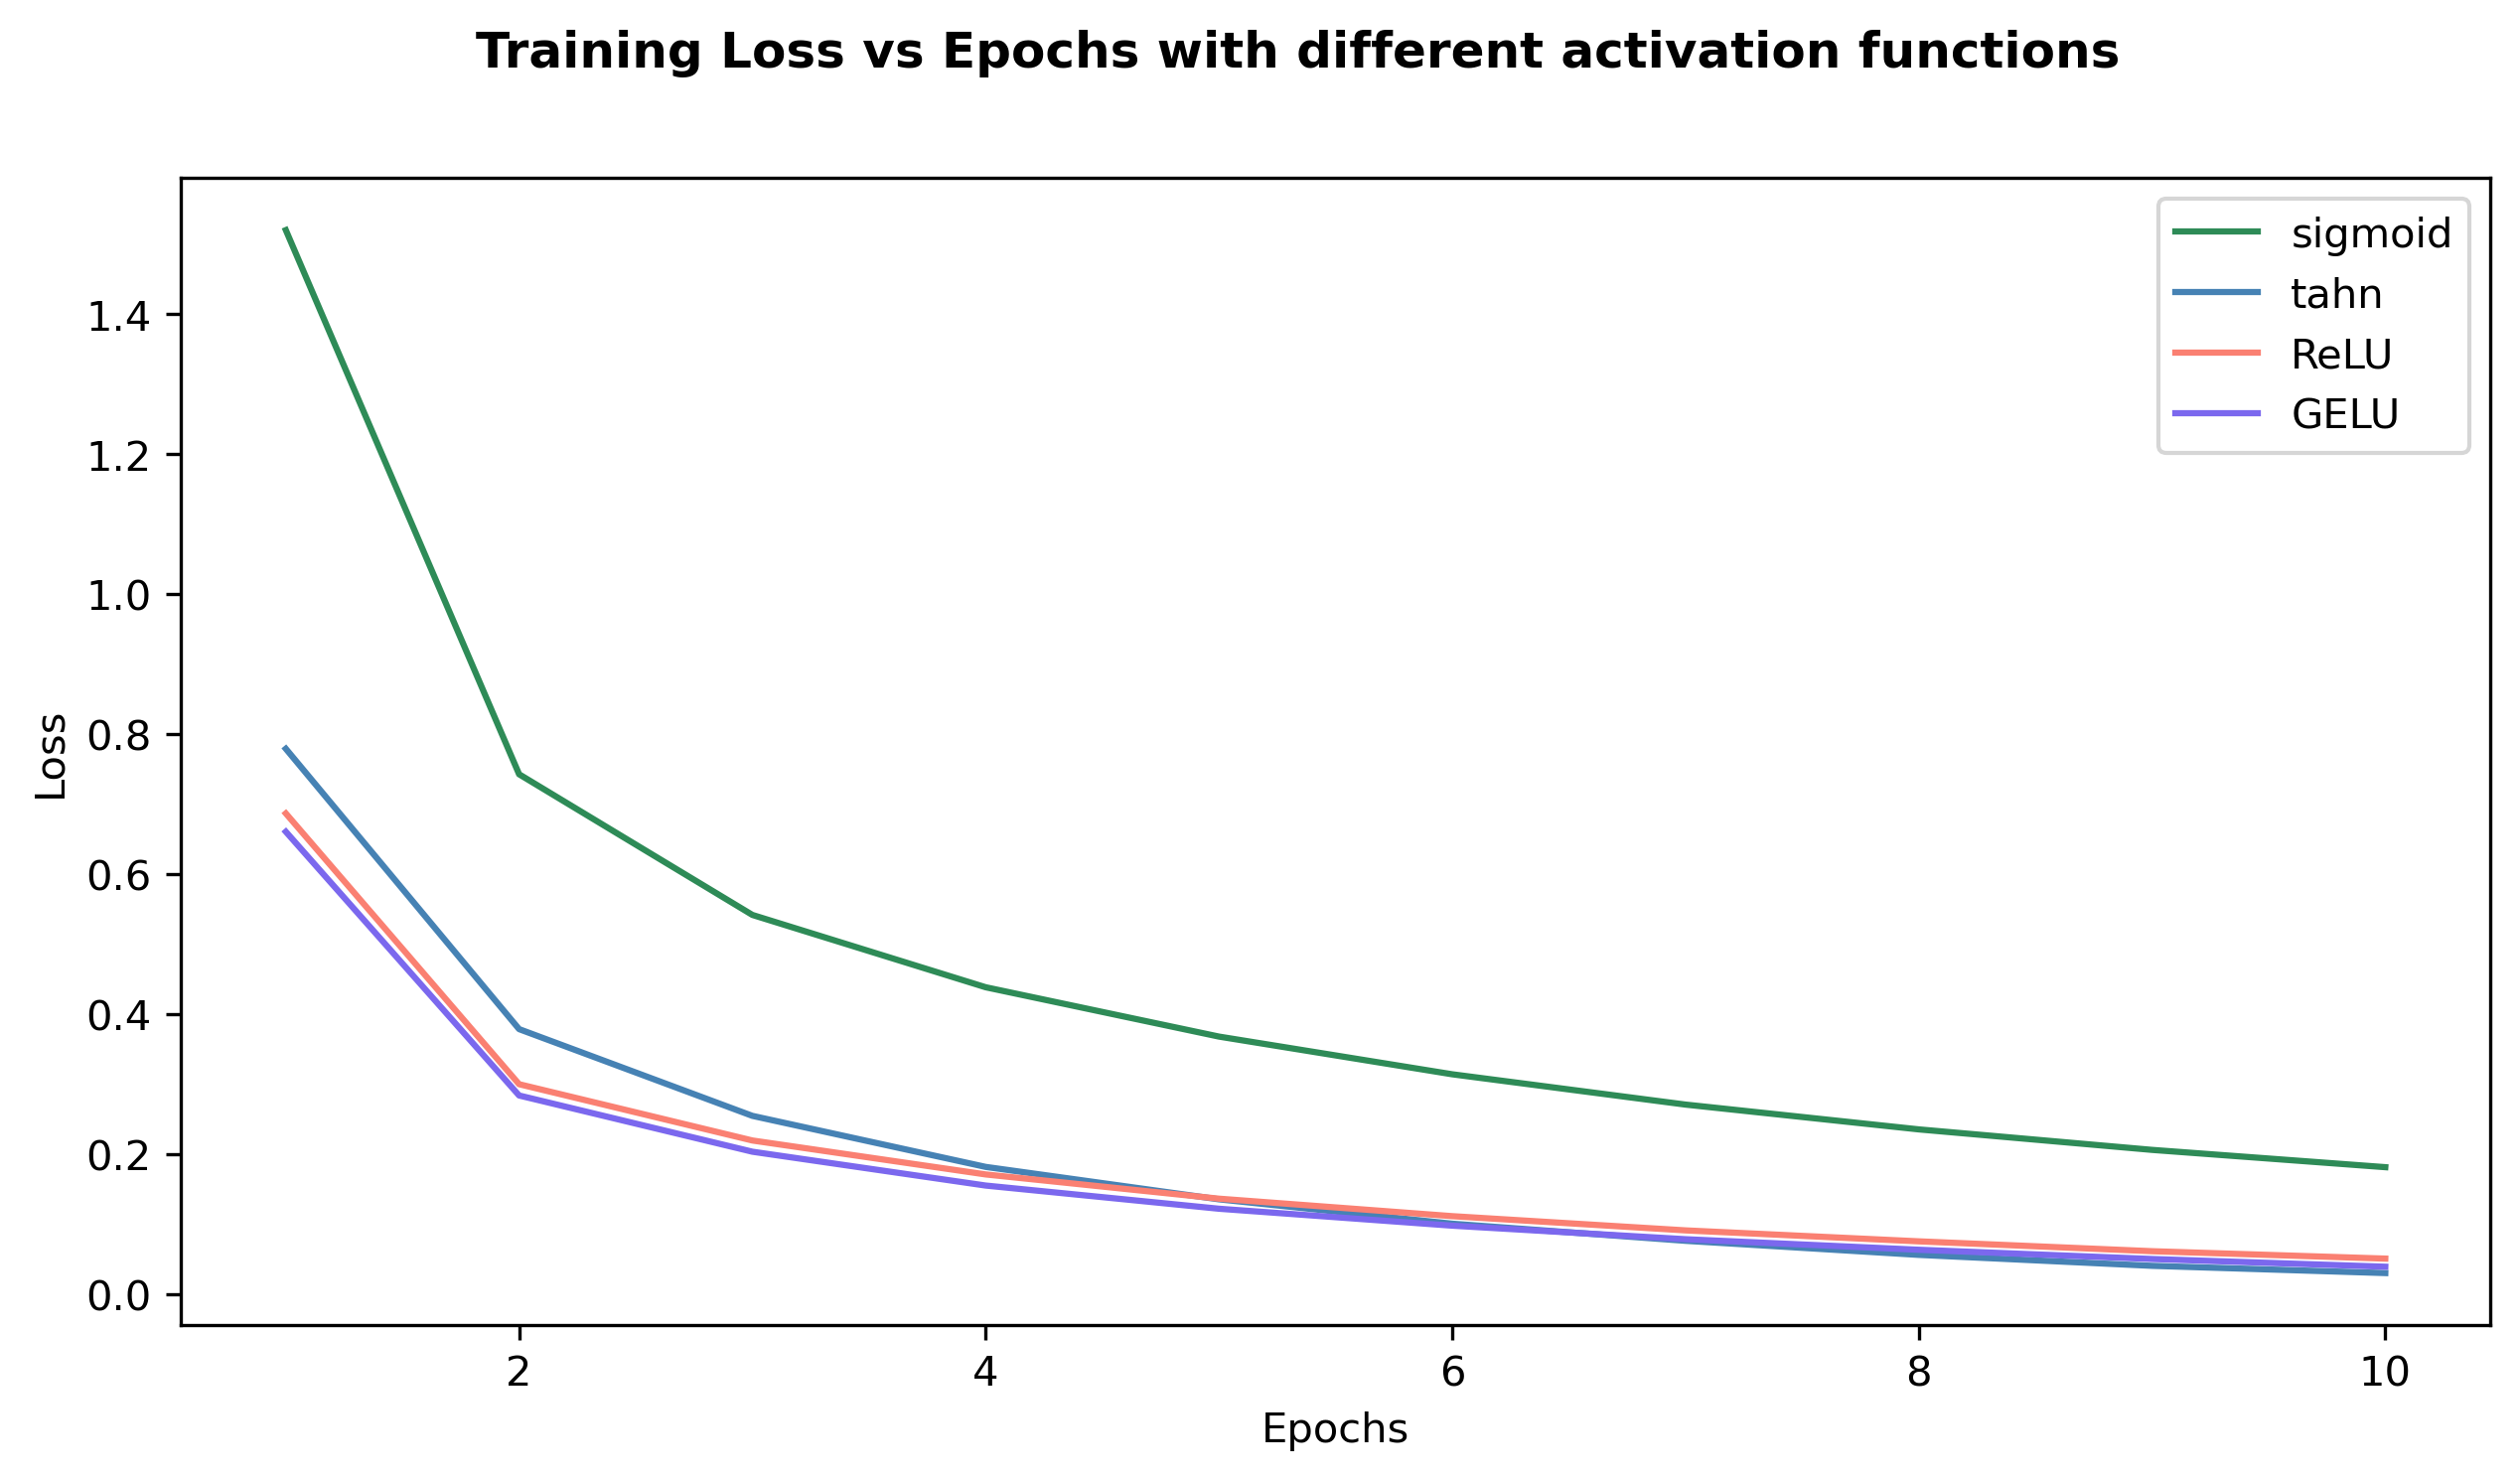

In [27]:
plt.figure(figsize=(10,5), dpi=300)
colors = ["seagreen", "steelblue", "salmon", "mediumslateblue"]
for i, item in enumerate(loss_histories.items()):
    plt.plot([i+1 for i in range(n_epochs)], item[1], label=item[0], c=colors[i])
plt.legend()
plt.suptitle("Training Loss vs Epochs with different activation functions", fontsize=12, fontweight="bold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

**Ответ:**

GELU was the best one (accuracy scores was 0.9009).

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [28]:
def test_optim(n_epochs, trainloader, testloader, optim):
    fc_net = FCNet_act(nn.GELU())
    optimizer = optim(fc_net.parameters(), lr=3e-4)
    loss_history = []
    print(optim.__name__)
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # training batch
            optimizer.zero_grad() # to reset the gradient
            outputs = fc_net(images) # predicting
            loss = loss_function(outputs, labels) # calculating loss
            loss.backward() # calculating gradient
            optimizer.step() # step of gradient descent

            epoch_loss += loss.item()

        loss_history.append(epoch_loss / len(trainloader))
        
        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
    print(f"accuracy score: {get_accuracy(fc_net, testloader)}")
    return loss_history

In [35]:
from torch.optim import Adam, RMSprop, Adagrad, AdamW


loss_function = nn.CrossEntropyLoss()
n_epochs = 10
loss_histories = {}

optims = [Adam, RMSprop, Adagrad, AdamW]
for optim in optims:
    loss_history = test_optim(n_epochs, trainloader, testloader, optim)
    loss_histories.update({optim.__name__: loss_history})

Adam
Epoch=1 loss=0.6673
Epoch=2 loss=0.2844
Epoch=3 loss=0.2043
Epoch=4 loss=0.1578
Epoch=5 loss=0.1243
Epoch=6 loss=0.0989
Epoch=7 loss=0.0801
Epoch=8 loss=0.0634
Epoch=9 loss=0.0506
Epoch=10 loss=0.0400
accuracy score: 0.9038
RMSprop
Epoch=1 loss=0.4423
Epoch=2 loss=0.2397
Epoch=3 loss=0.1757
Epoch=4 loss=0.1335
Epoch=5 loss=0.1043
Epoch=6 loss=0.0823
Epoch=7 loss=0.0648
Epoch=8 loss=0.0511
Epoch=9 loss=0.0394
Epoch=10 loss=0.0306
accuracy score: 0.905
Adagrad
Epoch=1 loss=1.3611
Epoch=2 loss=0.8260
Epoch=3 loss=0.6967
Epoch=4 loss=0.6316
Epoch=5 loss=0.5905
Epoch=6 loss=0.5610
Epoch=7 loss=0.5394
Epoch=8 loss=0.5206
Epoch=9 loss=0.5057
Epoch=10 loss=0.4926
accuracy score: 0.7219
AdamW
Epoch=1 loss=0.6654
Epoch=2 loss=0.2820
Epoch=3 loss=0.2035
Epoch=4 loss=0.1573
Epoch=5 loss=0.1244
Epoch=6 loss=0.1001
Epoch=7 loss=0.0804
Epoch=8 loss=0.0645
Epoch=9 loss=0.0521
Epoch=10 loss=0.0406
accuracy score: 0.9019


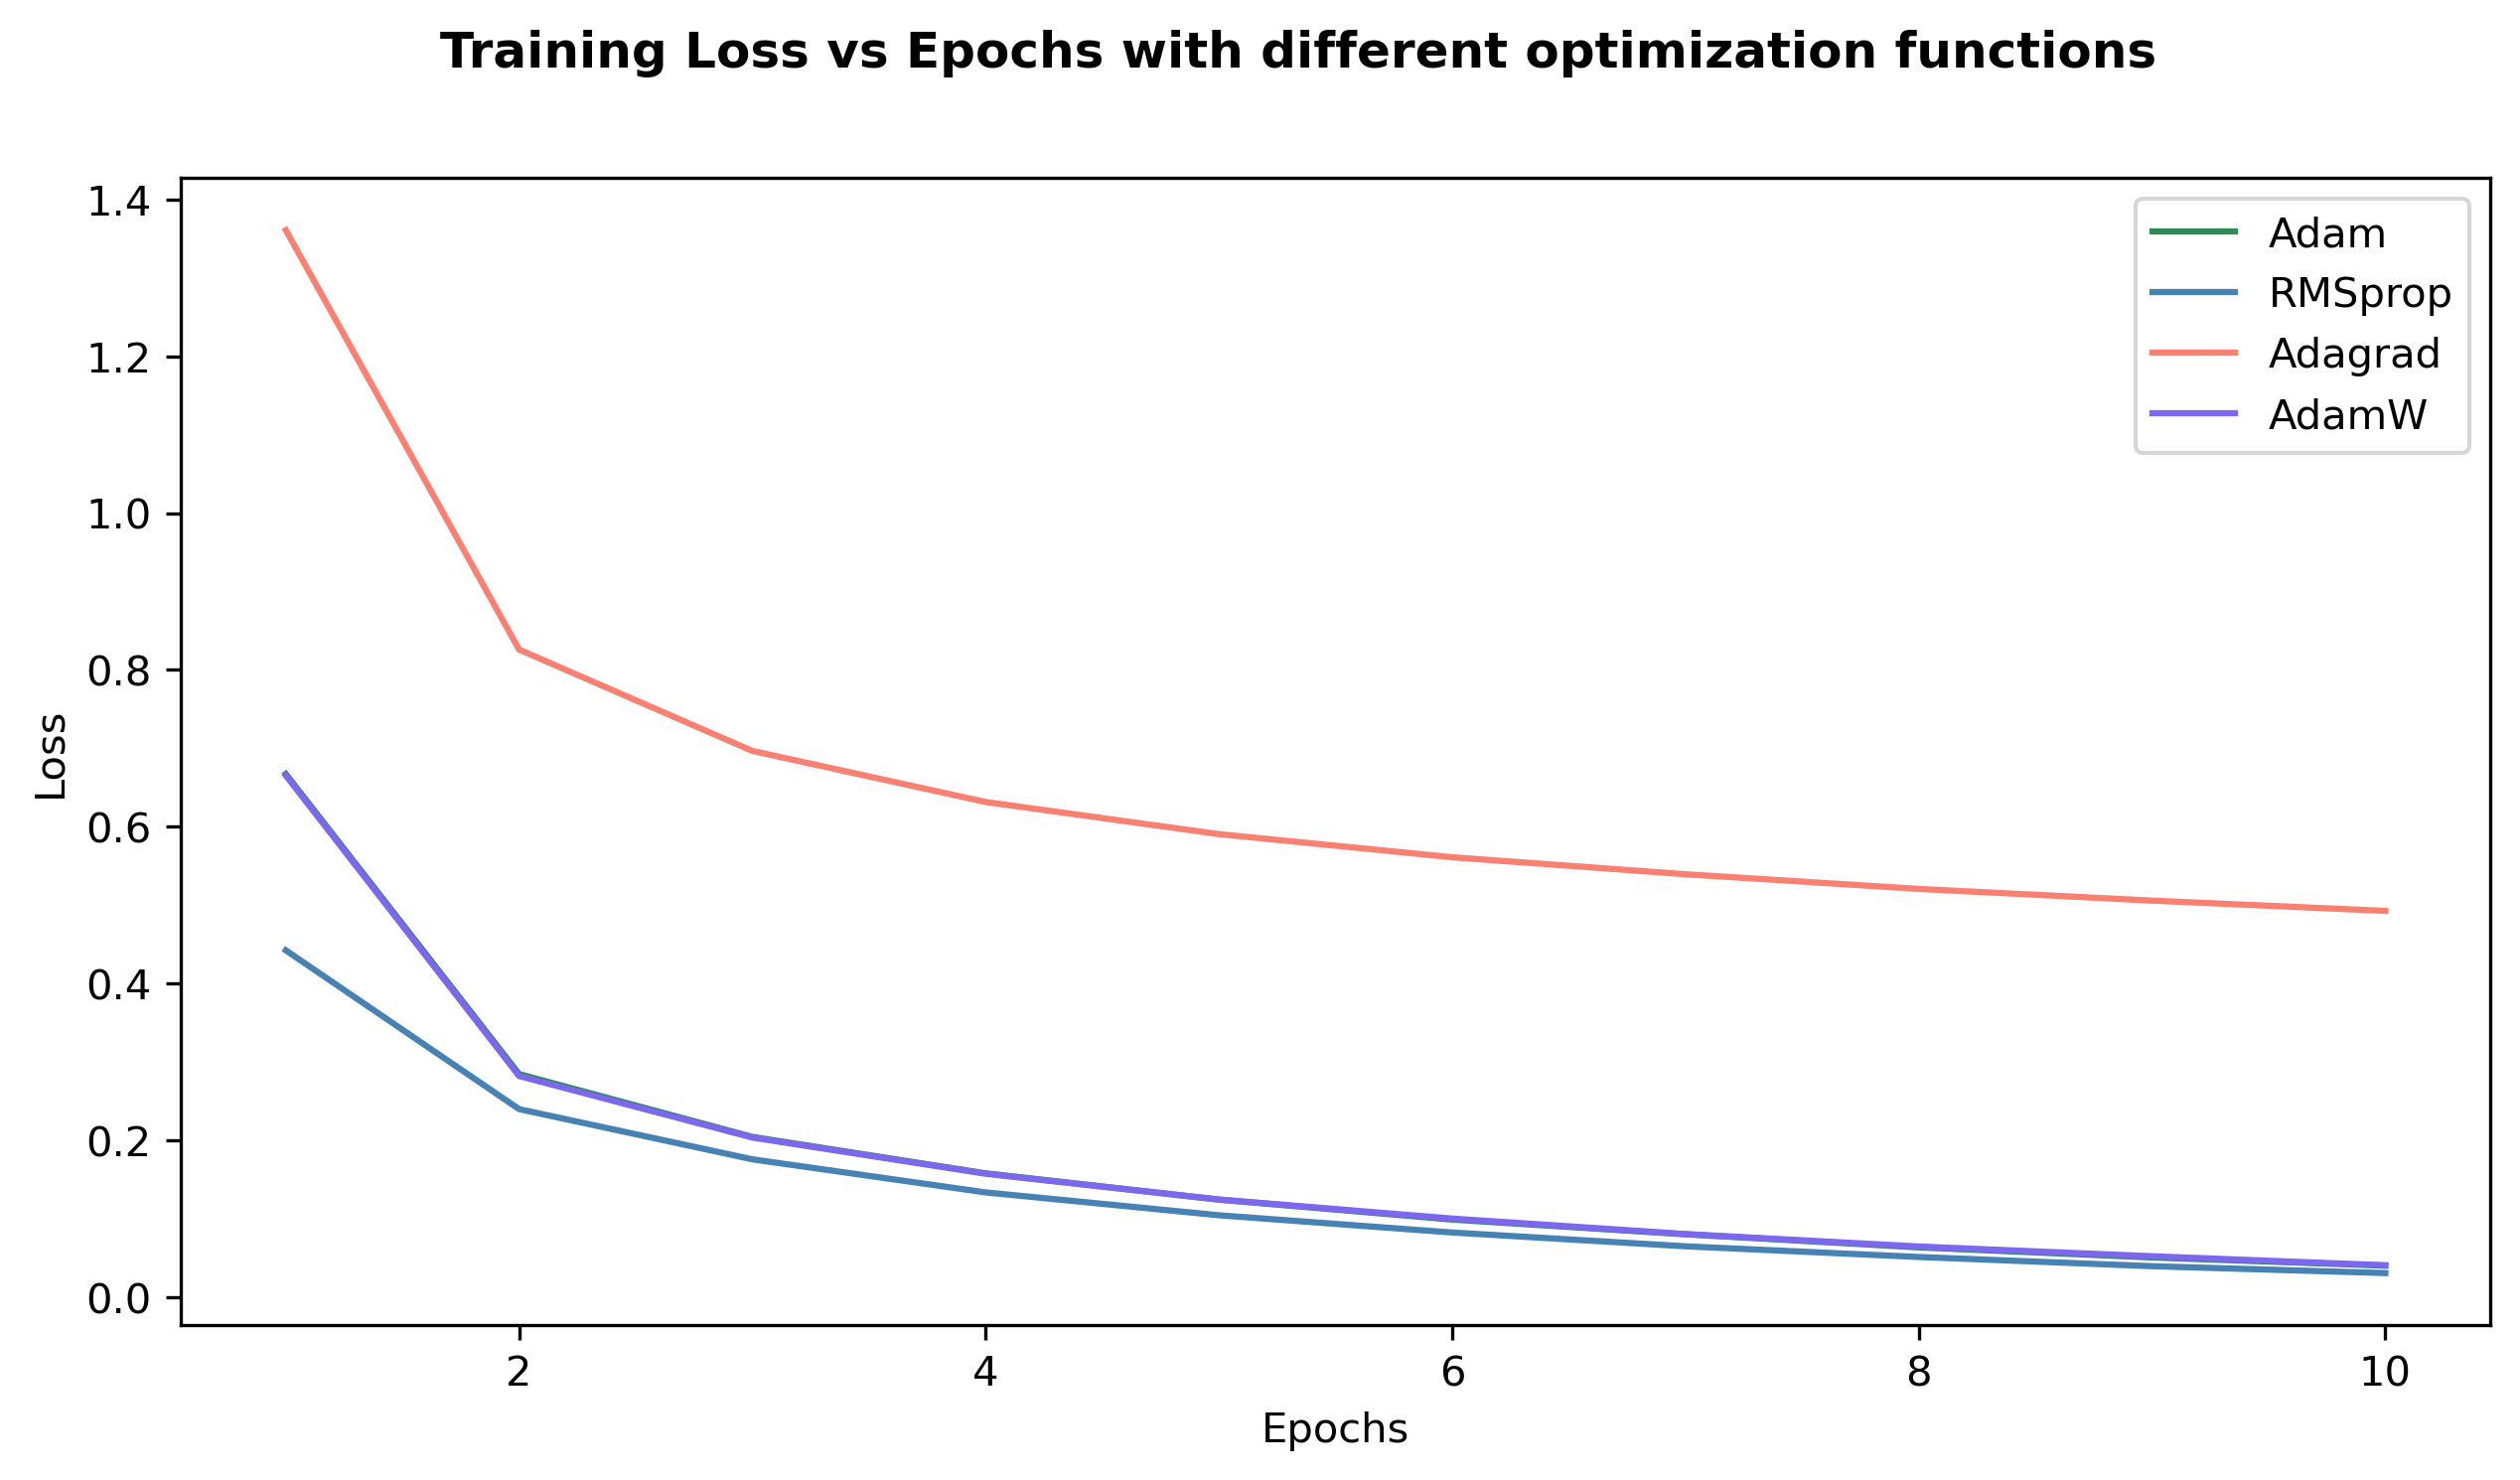

In [36]:
plt.figure(figsize=(10,5), dpi=300)
colors = ["seagreen", "steelblue", "salmon", "mediumslateblue"]
for i, item in enumerate(loss_histories.items()):
    plt.plot([i+1 for i in range(n_epochs)], item[1], label=item[0], c=colors[i])
plt.legend()
plt.suptitle("Training Loss vs Epochs with different optimization functions", fontsize=12, fontweight="bold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

As we can see, `RMSprop` and `AdamW` show a fairly rapid learning rate and a high accuracy score for our model. It is noteworthy that the loss of model with `AdamW` is almost equated to `RMSprop` after a couple of epochs. `Adam` and `AdamW` optmazition functions show almost the same parameters. 

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [31]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # если элемент x < 0, то 0, если >= 0, то x
        x = torch.maximum(x, torch.tensor([0]))
        # x[x < 0] = 0 ## it works too
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [38]:
loss_function = nn.CrossEntropyLoss()
n_epochs = 10
loss_histories = {}

act_funcs = [("ReLU", nn.ReLU()), ("CustomReLU", CustomReLU())]
for func in act_funcs:
    print(f"Actvation: {func[0]}")
    loss_history = test_optim(n_epochs, trainloader, testloader, AdamW)
    loss_histories.update({func[0]: loss_history})

Actvation: ReLU
AdamW
Epoch=1 loss=0.6620
Epoch=2 loss=0.2787
Epoch=3 loss=0.2027
Epoch=4 loss=0.1563
Epoch=5 loss=0.1221
Epoch=6 loss=0.0978
Epoch=7 loss=0.0790
Epoch=8 loss=0.0631
Epoch=9 loss=0.0510
Epoch=10 loss=0.0399
accuracy score: 0.8999
Actvation: CustomReLU
AdamW
Epoch=1 loss=0.6653
Epoch=2 loss=0.2791
Epoch=3 loss=0.1979
Epoch=4 loss=0.1514
Epoch=5 loss=0.1189
Epoch=6 loss=0.0939
Epoch=7 loss=0.0751
Epoch=8 loss=0.0608
Epoch=9 loss=0.0481
Epoch=10 loss=0.0376
accuracy score: 0.9063


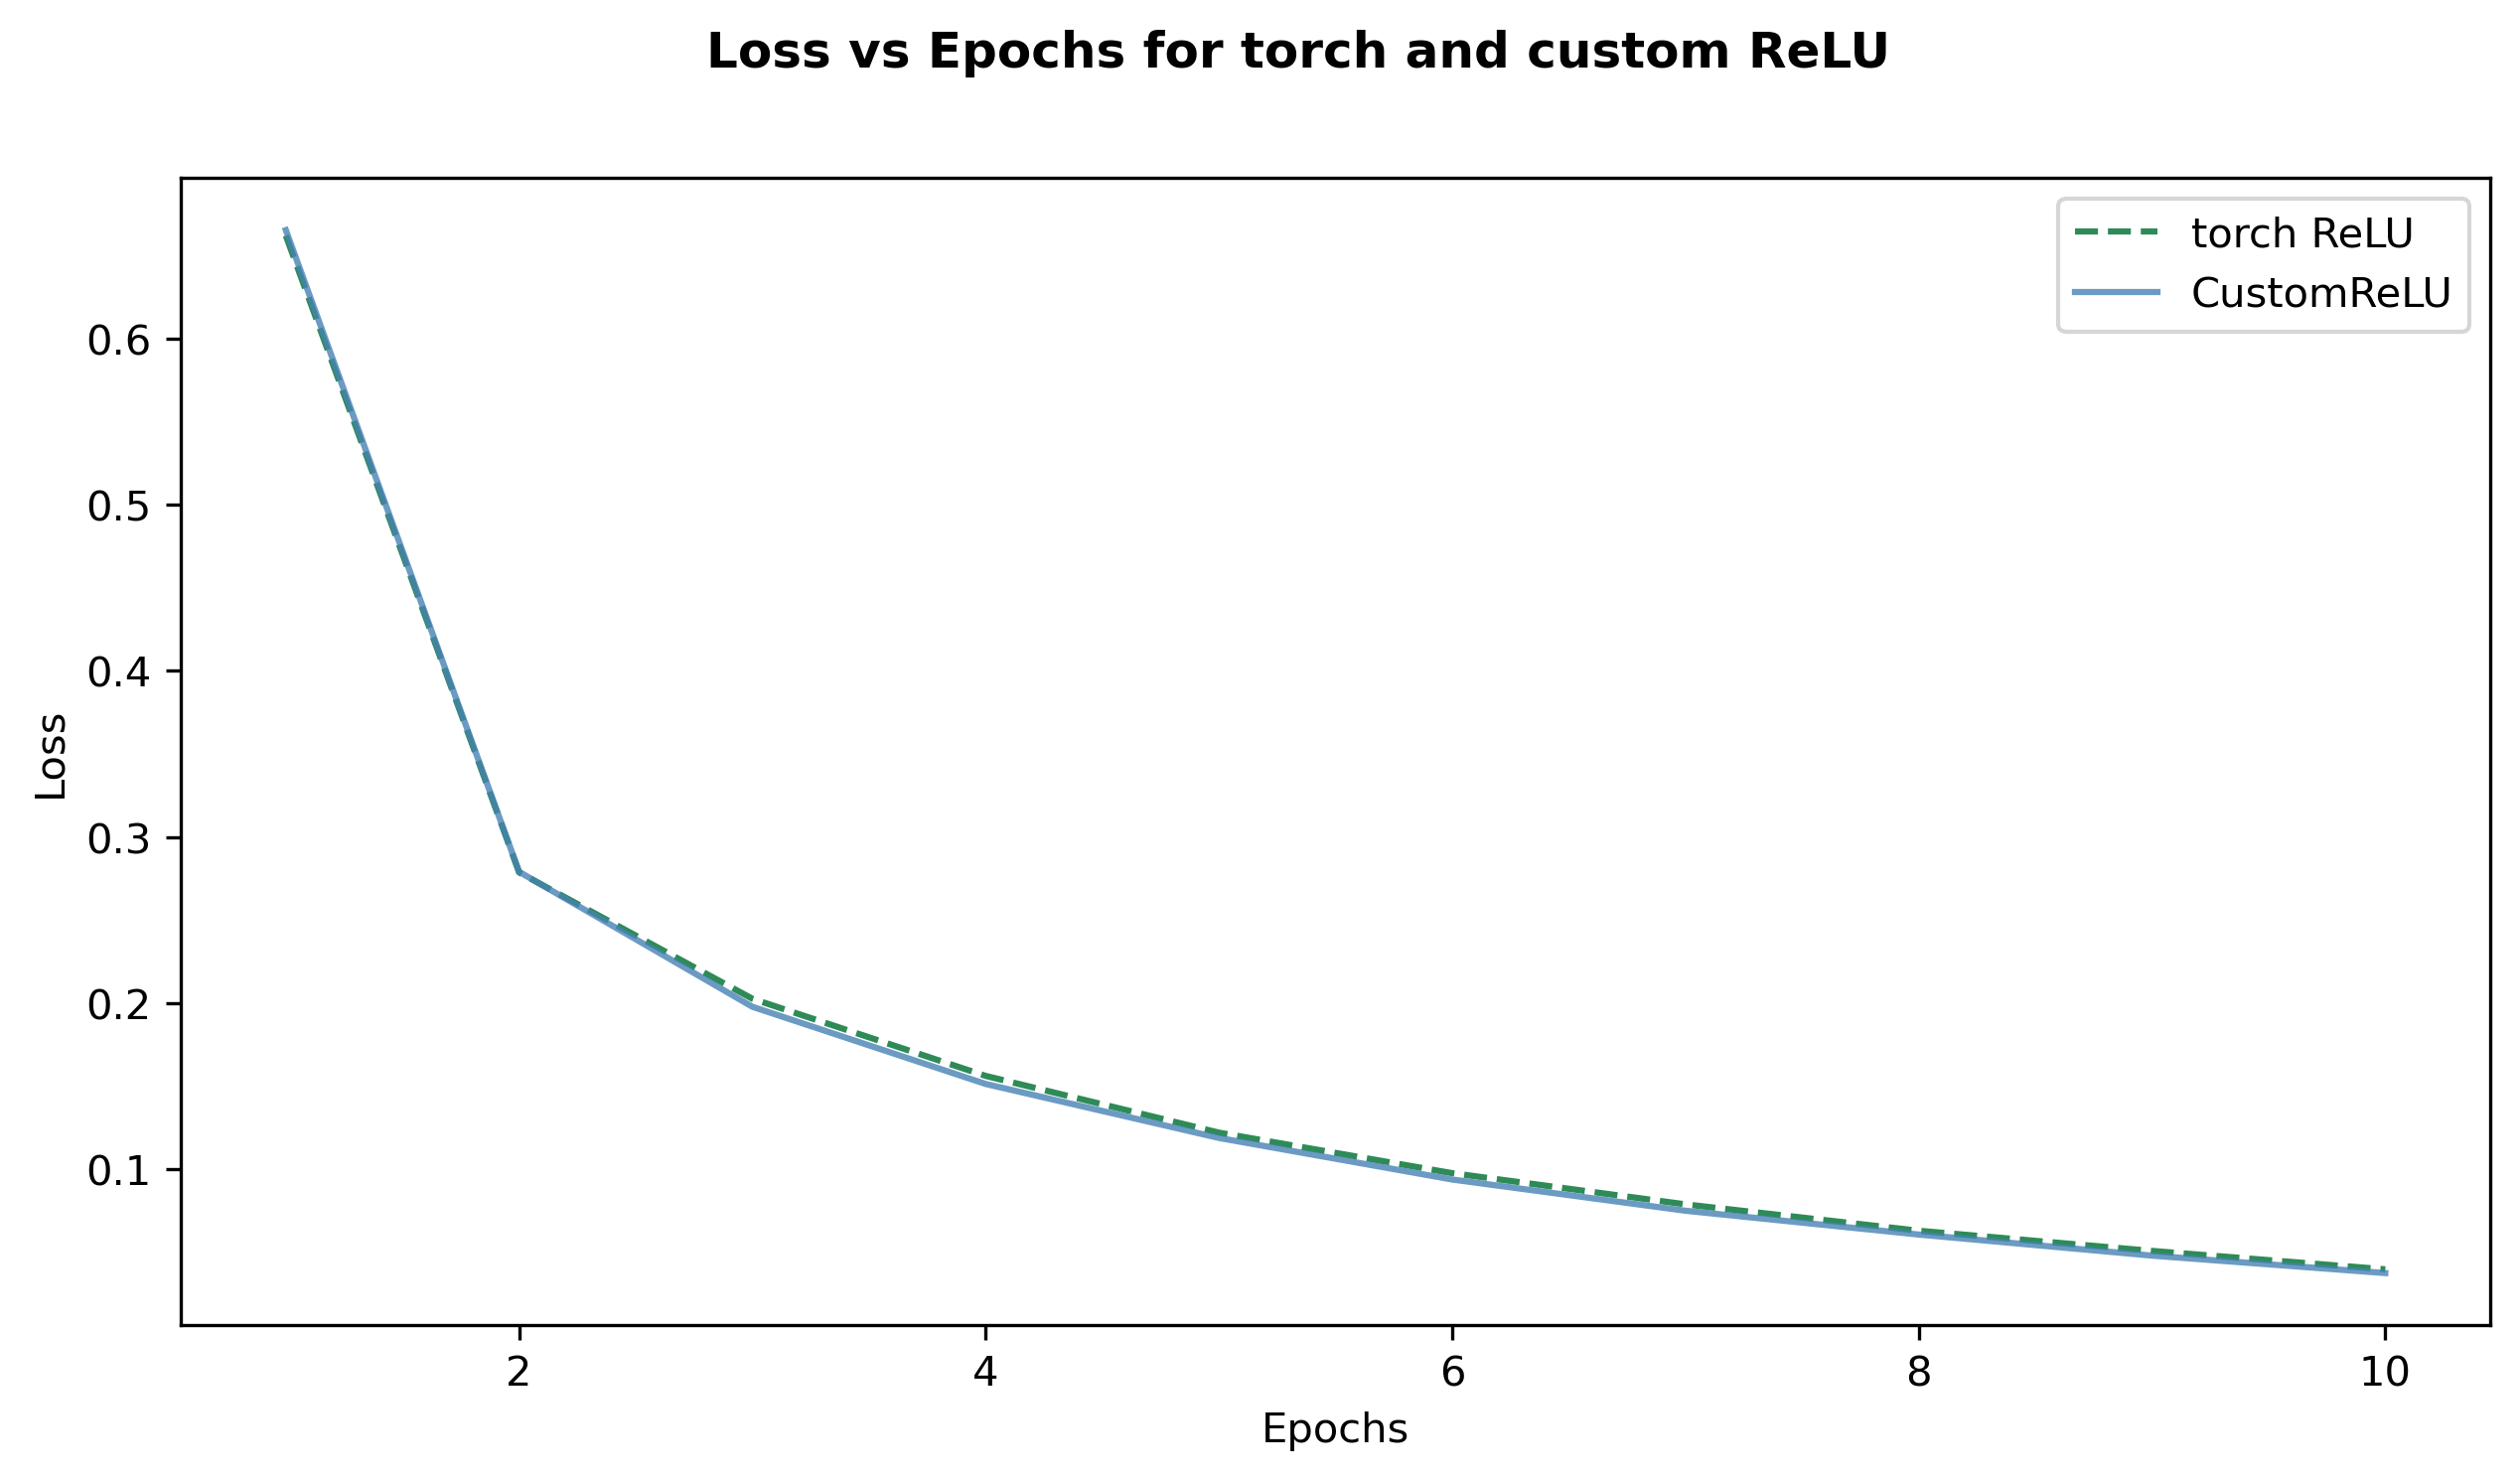

In [39]:
plt.figure(figsize=(10,5), dpi=300)
plt.plot([i+1 for i in range(n_epochs)], loss_histories["ReLU"], color="seagreen", linestyle="--", label="torch ReLU")
plt.plot([i+1 for i in range(n_epochs)], loss_histories["CustomReLU"], color="steelblue", alpha=0.8, label="CustomReLU")
plt.legend()
plt.suptitle("Loss vs Epochs for torch and custom ReLU", fontsize=12, fontweight="bold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

![figure1](../pictures/photo_2023-04-25_01-11-13.jpg)
![figure2](../pictures/photo_2023-04-25_01-14-01.jpg)
![figure3](../pictures/photo_2023-04-25_01-34-37.jpg)